In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GLM_helpers import *
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input

from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture


from allensdk.core.cell_types_cache import CellTypesCache

Using TensorFlow backend.


In [2]:
from scipy.stats import kurtosis, kurtosistest
x = np.random.normal(size=(10000,))
print kurtosis(x)

0.0106728305039


In [69]:
D = np.load('exc_clumps.npz')
F_clump = D['arr_0']
W_clump = D['arr_1']
b_clump = D['arr_2']
d=W_clump.shape[1]
bin_len=0.001
print W_clump.shape

(313, 30)


In [70]:
ncomp = 2

W_means = np.empty((ncomp,d))
W_vars = np.empty((ncomp,d))
W_weights = np.empty((ncomp,d))
for i in range(d):
    gm = GaussianMixture(n_components=ncomp,n_init=1)
    gm.fit(np.expand_dims(W_clump[:,i],1))
    order = np.argsort(gm.means_.squeeze())
    W_means[:,i] = gm.means_.squeeze()[order]
    W_vars[:,i] = gm.covariances_.squeeze()[order]
    W_weights[:,i] = gm.weights_.squeeze()[order]
    
F_means = np.empty((ncomp,d))
F_vars = np.empty((ncomp,d))
F_weights = np.empty((ncomp,d))
for i in range(d):
    gm = GaussianMixture(n_components=ncomp,n_init=1)
    gm.fit(np.expand_dims(F_clump[:,i],1))
    order = np.argsort(gm.means_.squeeze())
    F_means[:,i] = gm.means_.squeeze()[order]
    F_vars[:,i] = gm.covariances_.squeeze()[order]
    F_weights[:,i] = gm.weights_.squeeze()[order]


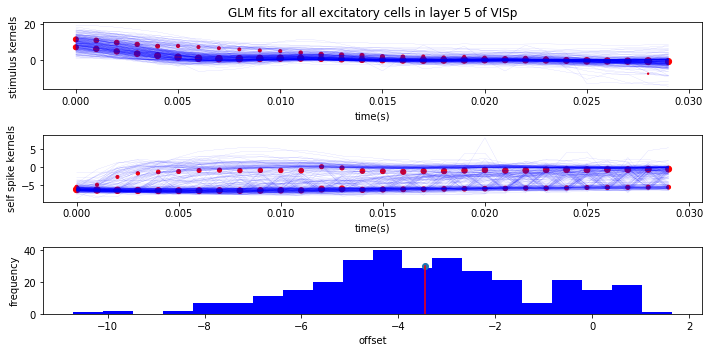

In [71]:
from matplotlib.collections import LineCollection
def plot_thick(x,y,w,color):
    for j in range(y.shape[1]):
        plt.scatter(x,y[:,j],c=color,s=w[:,j])

t = np.arange(d)*bin_len

F_kurts = kurtosis(F_clump,axis = 0)
(z_F,p_F) = kurtosistest(F_clump,axis = 0)
W_kurts = kurtosis(W_clump,axis = 0)
(z_W,p_W) = kurtosistest(W_clump,axis = 0)
b_mean = np.mean(b_clump)
b_std = np.std(b_clump)
b_kurt = kurtosis(b_clump)
(z_b,p_b) = kurtosistest(b_clump)

plt.subplots(3,1,figsize = (10,5))
plt.subplot(3,1,1)
plt.plot(t,F_clump.T,'b',linewidth = 0.1,alpha=0.5)
plot_thick(t,F_means.T,F_weights.T*50,'r')
# plt.plot(t,F_means.T,'r',linewidth = 1)
plt.xlabel('time(s)')
plt.ylabel('stimulus kernels')
plt.title('GLM fits for all excitatory cells in layer 5 of VISp')

plt.subplot(3,1,2)
plt.plot(t,W_clump.T,'b',linewidth = 0.1,alpha=0.5)
# plt.plot(t,W_means.T,'r',linewidth = 1)
plot_thick(t,W_means.T,W_weights.T*50,'r')
plt.xlabel('time(s)')
plt.ylabel('self spike kernels')

plt.subplot(3,1,3)
plt.hist(b_clump,bins = 20,color='b')
plt.stem([b_mean],[30],'r')
plt.xlabel('offset')
plt.ylabel('frequency')
plt.tight_layout()

# ax[1].xlabel('time(s)')
# ax[0].ylabel('stimulus kernel value')
# ax[1].ylabel('self spike kernel value')
# ax[2].xlabel('offset')
# ax[2].ylabel('frequency')



/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


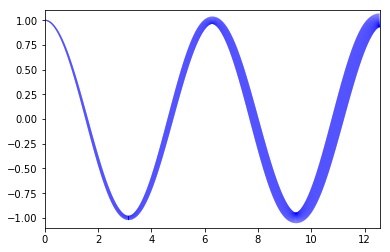

In [21]:
x = np.linspace(0,4*np.pi,10000)
y = np.cos(x)
lwidths=1+x[:-1]
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, linewidths=lwidths,color='blue')
fig,a = plt.subplots()
a.add_collection(lc)
a.set_xlim(0,4*np.pi)
a.set_ylim(-1.1,1.1)
fig.show()


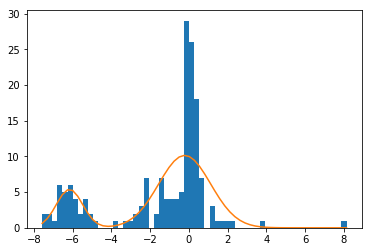

In [6]:
i=20
gm = GaussianMixture(n_components=2,n_init=1)
gm.fit(np.expand_dims(W_clump[:,i],1))

nbins = 60
(_,bins,_) = plt.hist(W_clump[:,i],bins=nbins)
plt.plot(bins,len(W_clump[:,i])*(bins[1]-bins[0])*np.exp(gm.score_samples(bins.reshape(-1, 1))))

In [ ]:
from keras.regularizers import Regularizer
from keras import backend as K

class SparseGroupLasso(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, size_stim, d_spike, priors = None, lprior = 0 lgroup = 0.):
        self.lgroup = K.cast_to_floatx(lgroup)
        if priors is not None:
            self.lprior = K.cast_to_floatx(lprior)
            (self.W_means, self.W_vars, self.W_weights) = priors
            
        else:
            self.lprior = 0
            
        self.d_spike = d_spike
        self.size_stim = size_stim

    def __call__(self, x): 
        xr = K.reshape(x[self.size_stim:], (-1, self.d_spike))
        pen = self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1)))
        if self.lprior > 0
            pen += self.lprior * K.sum(K.log(K.sum(self.W_weights*K.exp(-0.5*K.square(xr-self.W_means)/self.W_vars),axis=0)),axis=1)
        return pen
